In [1]:
import rosbag
import matplotlib.pyplot as plt
import allantools
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
import bagpy
from bagpy import bagreader

In [2]:
read = bagreader('Long_data.bag')
read_stats = read.message_by_topic('/imu')
imu_df = pd.read_csv(read_stats)

[INFO]  Data folder 2022-10-19-01-23-30 already exists. Not creating.


In [20]:
# Frequency
ts = 1/40

In [21]:

# Allan Deviation Function 
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )
    
    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))



In [22]:
# Bias Instability
def Bias_ins(tau,ad):
    slope = 0
    logtau = np.log10(tau)
    logad = np.log10(ad)
    dlogadev = np.diff(logad) / np.diff(logtau)
    i = np.argmin(np.abs(dlogadev - slope))
    b = logad[i] - slope*logtau[i]

    scfB = np.sqrt(2*np.log(2)/np.pi)
    logB = b - np.log10(scfB)
    B = 10**logB
    


    return B

In [23]:
# Random Walk
def Rate_rnd_wlk(tau,ad):
    slope = 0.5
    logtau = np.log10(tau)
    logad = np.log10(ad)
    dlogadev = np.diff(logad) / np.diff(logtau)
    i = np.argmin(np.abs(dlogadev - slope))
    b = logad[i] - slope*logtau[i]
    logK = slope*np.log10(3) + b
    K = 10**logK
    return K

In [34]:
#Gyroscope
gx = imu_df['IMU.angular_velocity.x'].to_numpy() * (180/np.pi)
gy = imu_df['IMU.angular_velocity.y'].to_numpy() * (180/np.pi)
gz = imu_df['IMU.angular_velocity.z'].to_numpy() * (180/np.pi)
thetax = np.cumsum(gx)*ts
thetay = np.cumsum(gy)*ts
thetaz = np.cumsum(gz)*ts
(taux, adx) = AllanDeviation(thetax, 40.0, maxNumM = 3000)
(tauy, ady) = AllanDeviation(thetay, 40.0, maxNumM = 3000)
(tauz, adz) = AllanDeviation(thetaz, 40.0, maxNumM = 3000)


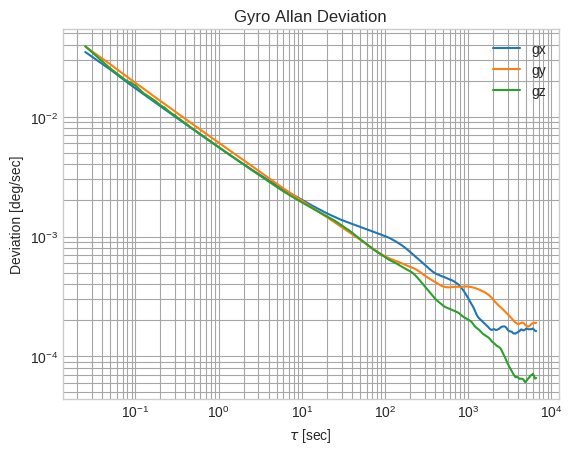

In [35]:
plt.figure()
plt.title('Gyro Allan Deviation')
plt.plot(taux, adx, label = 'gx')
plt.plot(tauy, ady, label = 'gy')
plt.plot(tauz, adz, label = 'gz')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel('Deviation [deg/sec]')
plt.grid(True, which = "both", ls = '-', color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [28]:
print("\nBias Instability [deg/hr]")
print((Bias_ins(taux,adx)/0.664)*3600)
print((Bias_ins(tauy,ady)/0.664)*3600)
print((Bias_ins(tauz,adz)/0.664)*3600)

print("\nAngle Rate Random Walk [deg/sec (sqrt(Hz))]")
print(Rate_rnd_wlk(taux,adx))
print(Rate_rnd_wlk(tauy,ady))
print(Rate_rnd_wlk(tauz,adz))


Bias Instability [deg/hr]
1.3719598625528957
3.0972722966746793
0.5289221093787566

Angle Rate Random Walk [deg/sec (sqrt(Hz))]
6.103764200211175e-06
4.23935487295135e-06
1.5832399530845806e-06


In [40]:
# Accelerometer 
ax = imu_df['IMU.linear_acceleration.x'].to_numpy()*(1000/9.81)
ay = imu_df['IMU.linear_acceleration.y'].to_numpy()*(1000/9.81)
az = imu_df['IMU.linear_acceleration.z'].to_numpy()*(1000/9.81)


x = np.cumsum(ax)*ts
y = np.cumsum(ay)*ts
z = np.cumsum(az)*ts

(taux, adx) = AllanDeviation(x, 40.0, maxNumM = 3000)
(tauy, ady) = AllanDeviation(y, 40.0, maxNumM = 3000)
(tauz, adz) = AllanDeviation(z, 40.0, maxNumM = 3000)


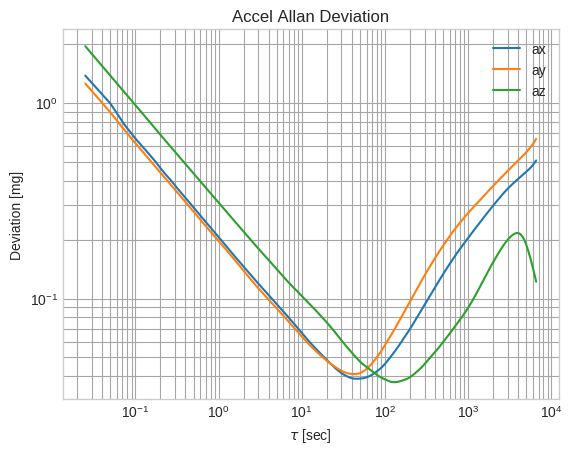

In [41]:
plt.figure()
plt.title('Accel Allan Deviation')
plt.plot(taux, adx, label = 'ax')
plt.plot(tauy, ady, label = 'ay')
plt.plot(tauz, adz, label = 'az')
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel('Deviation [mg]')
plt.grid(True, which = "both", ls = '-', color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [42]:


print("\nBias Instability [mg]")
print(Bias_ins(taux,adx))
print(Bias_ins(tauy,ady))
print(Bias_ins(tauz,adz))

print("\nVelocity Rate Random Walk ")
print(Rate_rnd_wlk(taux,adx))
print(Rate_rnd_wlk(tauy,ady))
print(Rate_rnd_wlk(tauz,adz))


Bias Instability [mg]
0.058597401778397326
0.061909472907145456
0.05629284071201202

Velocity Rate Random Walk 
0.011600266742164527
0.01368191651558229
0.00463041028566747
